### Data Cleaning Data Quality

During the last notebooks we have been worked with a dataset of a good data quality. There were no outliners and no missing data inside. But in the real world you have to fight with all these problems. On my experiences the effort to clean this data is much higher than build good model for forecasting purposes.

In this notebook I will show you some effect of a bad data quality

#### Preparation

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow import keras
import tensorflow as tf
from IPython.display import display

seed=8172
np.random.seed(seed)
tf.random.set_seed(seed)
ts_input_size=12
ts_target_size=1
forecast_size=12
# Read the data
df=pd.read_csv("../data/AirPassengers.csv")
df.columns=["Period","Passengers"]
dfTraining=df.iloc[:-forecast_size].copy()

# Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0.1, 0.9))
series_scaled = scaler.fit_transform(dfTraining["Passengers"].values.reshape(-1,1))
dfTraining["PassengersScaled"]=series_scaled
display(dfTraining.head(5))
display(dfTraining.tail(5))

,Period,Passengers,PassengersScaled
0,1949-01,112,0.114066
1,1949-02,118,0.124615
2,1949-03,132,0.149231
3,1949-04,129,0.143956
4,1949-05,121,0.129890


,Period,Passengers,PassengersScaled
127,1959-08,559,0.900000
128,1959-09,463,0.731209
129,1959-10,407,0.632747
130,1959-11,362,0.553626
131,1959-12,405,0.629231


Setting the target size to 1 period element reduces the missing gap at the end of the training data

In [2]:

training_flat=dfTraining["PassengersScaled"].values.reshape(-1,1).astype("float32")
trainX=[]
trainY=[]
for i in range(len(training_flat)-ts_target_size-ts_input_size+1):
    x=training_flat[i:(i+ts_input_size),0]
    y=training_flat[(i+ts_input_size):(i+ts_input_size+ts_target_size),0]
    trainX.append(x)
    trainY.append(y)

# Training data
trainX=np.array(trainX)
trainY=np.array(trainY)
from sklearn.model_selection import train_test_split
x_trainbatches, x_testbatches, y_trainbatches, y_testbatches = train_test_split(
            trainX, trainY, test_size=0.1, random_state=42)
x_testbatches

# Forecast input
predictX=[training_flat[-ts_input_size:,0]]


In [3]:
display(dfTraining.tail(24))
print("Last observation X: {}".format(trainX[-1]))
print("Last observation Y: {}".format(trainY[-1]))

,Period,Passengers,PassengersScaled
108,1958-01,340,0.514945
109,1958-02,318,0.476264
110,1958-03,362,0.553626
111,1958-04,348,0.529011
112,1958-05,363,0.555385
113,1958-06,435,0.681978
114,1958-07,491,0.780440
115,1958-08,505,0.805055
116,1958-09,404,0.627473
117,1958-10,359,0.548352


Last observation X: [0.5096703  0.55010986 0.5184615  0.630989   0.6134066  0.6556044
 0.74703294 0.88065934 0.9        0.7312088  0.63274723 0.55362636]
Last observation Y: [0.6292308]


Next, there are some functions for the reports and also for the training process. The functions were already used in the notebooks before

In [4]:
def show_loss(history,skipFirst=True):
    print("Last Results loss:{}, cross validation loss:{}".format(history.history['loss'][-1],history.history['val_loss'][-1]))
    plt.figure(figsize=(20,10))
    start=100 if skipFirst else 0
    plt.plot(history.history["val_loss"][start:], label="Cross Validation Loss")
    plt.plot(history.history["loss"][start:], label="Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Mean Squared Error")
    plt.title("Loss Results - Training vs. Cross Validation (Mean Squared Error)")
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.show()  

def show_results(df,predictX,predictY):
    outputsize=len(predictY[0])
    inputsize=len(predictX[0])
    absDeviation=np.sum(np.abs(df["Passengers"].values[-outputsize:]-predictY[0]))
    absError=absDeviation/np.sum(predictY[0])*100
    print("          Forecast : {}\r\n            Actual : {}\r\nAbsolute Deviation : {} Passengers\r\n    Absolute Error : {:3.2f}%".format(
        predictY.astype(int)[0],df["Passengers"].values[-outputsize:],absDeviation,absError))    
    y0=df["Passengers"].values
    y1=[None for x in range(df.shape[0]-outputsize-inputsize)]
    y1.extend(predictX[0])
    y1=np.array(y1)
    y2=[None for x in range(df.shape[0]-outputsize)]
    y2.extend(predictY[0])
    y2=np.array(y2)
    plt.figure(figsize=(20,10))
    plt.plot(y0,label='Actual')
    plt.plot(y1,label='Input for Forecast')
    plt.plot(y2, label= 'Forecast')
    plt.xlabel("Period")
    labels=[df["Period"].iloc[x] for x in range(0,df.shape[0],12)]
    plt.xticks(range(0,df.shape[0],12),labels=labels, rotation=45)
    plt.ylabel("Number of Passenger")
    plt.title("Forecast Airline Passenger")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.show()    


def buildAndTrainModel(layerSize1,layerSize2,x_trainbatches, x_testbatches, y_trainbatches, y_testbatches, usebias=True):
    model=keras.Sequential()
    model.add(keras.layers.Dense(layerSize1,activation=keras.layers.LeakyReLU(), input_dim=ts_input_size, use_bias=usebias))
    if layerSize2 is not None:
        model.add(keras.layers.Dense(layerSize2,activation=keras.layers.LeakyReLU(), use_bias=usebias))
    model.add(keras.layers.Dense(ts_target_size, activation=keras.layers.LeakyReLU(), use_bias=usebias))

    model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['mean_squared_error']
    )
    earlyStopCB= keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0,patience=300,verbose=0,mode='auto')
    history=model.fit(x_trainbatches, y_trainbatches, epochs=10000,verbose=0,
                               batch_size=len(x_trainbatches),
                               validation_data=(x_testbatches, y_testbatches),
                               use_multiprocessing=True, callbacks=[earlyStopCB])
    return model,history

def predict(model, predictX, forecast_size,ts_target_size):
    result =None
    predictInput=np.array(predictX)
    for loop in range(0,forecast_size,ts_target_size):
        predictOutput=model.predict(predictInput)
        result=predictOutput if result is None else np.append(result,predictOutput)
        predictInput=np.reshape(np.append(predictInput[-1,ts_target_size:],predictOutput),(1,-1))
    return np.reshape(result,(1,-1))



Last Results loss:0.0005128701450303197, cross validation loss:0.00046421829028986394


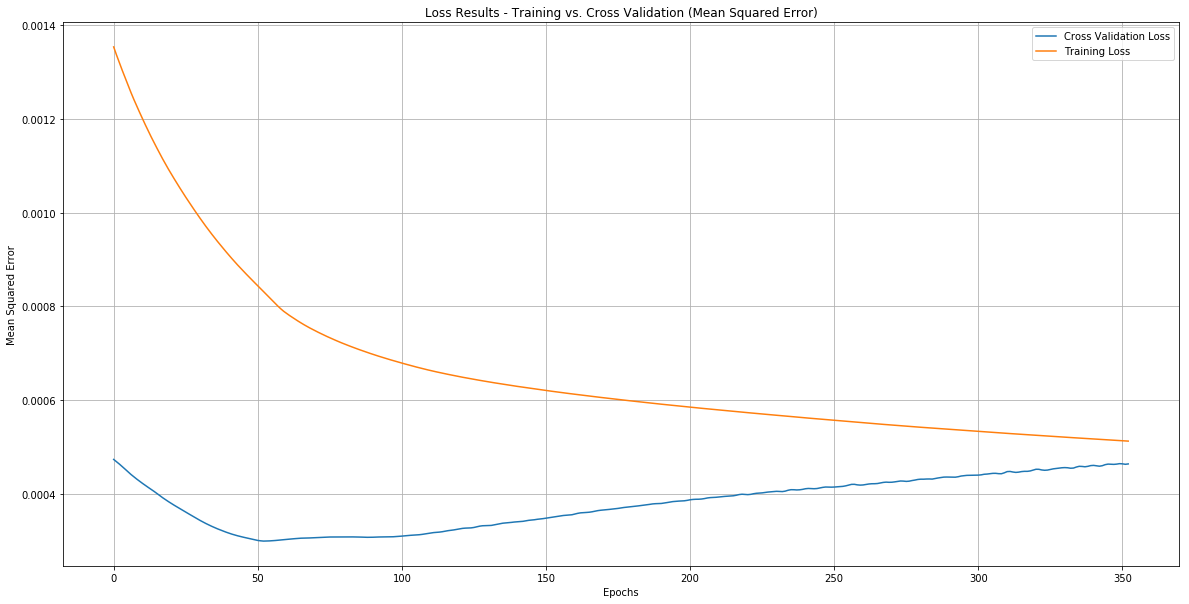

In [5]:
model,history=buildAndTrainModel(67,13,x_trainbatches, x_testbatches, y_trainbatches, y_testbatches,True)
show_loss(history)

          Forecast : [400 387 419 428 459 513 593 606 531 450 406 436]
            Actual : [417 391 419 461 472 535 622 606 508 461 390 432]
Absolute Deviation : 171.61972045898438 Passengers
    Absolute Error : 3.05%


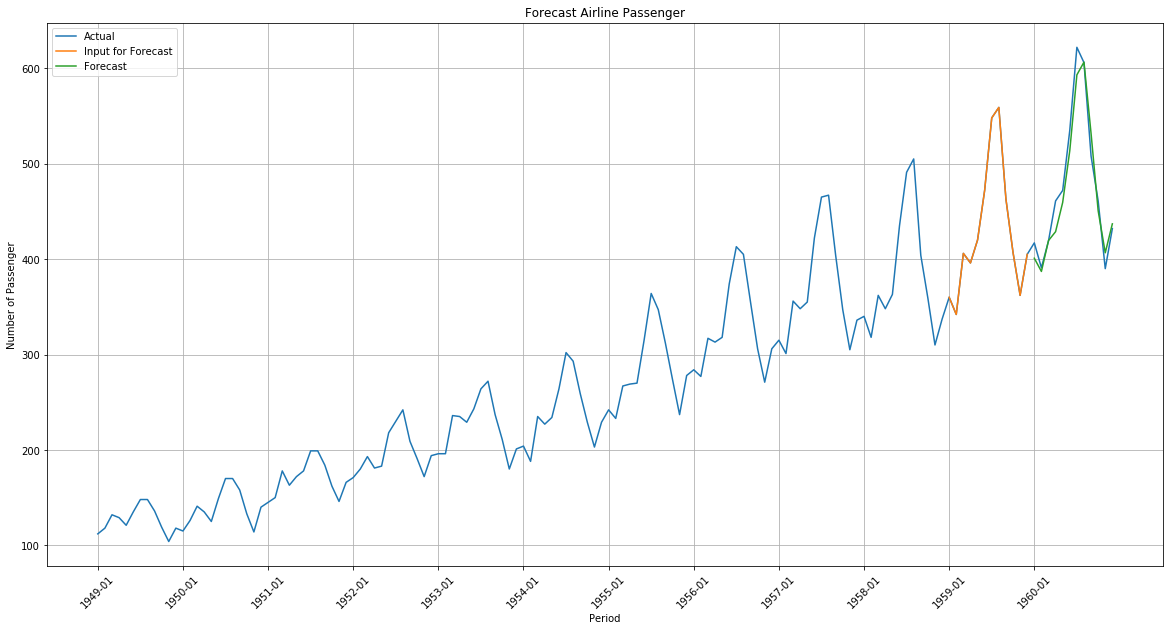

In [6]:

predictY=predict(model,predictX,forecast_size,ts_target_size)
show_results(df,scaler.inverse_transform(predictX),scaler.inverse_transform(predictY))
      

### Missing Periods

In this case I drop one period of the training data. This is one common problem you get with real data. Exports of data often skips rows with Null values.  

In [7]:
dfTraining2=dfTraining.drop(dfTraining[dfTraining.Period=="1958-08"].index)
dfTraining2.loc[107:119]

,Period,Passengers,PassengersScaled
107,1957-12,336,0.507912
108,1958-01,340,0.514945
109,1958-02,318,0.476264
110,1958-03,362,0.553626
111,1958-04,348,0.529011
112,1958-05,363,0.555385
113,1958-06,435,0.681978
114,1958-07,491,0.780440
116,1958-09,404,0.627473
117,1958-10,359,0.548352


Last Results loss:0.0009943684563040733, cross validation loss:0.0010010480182245374


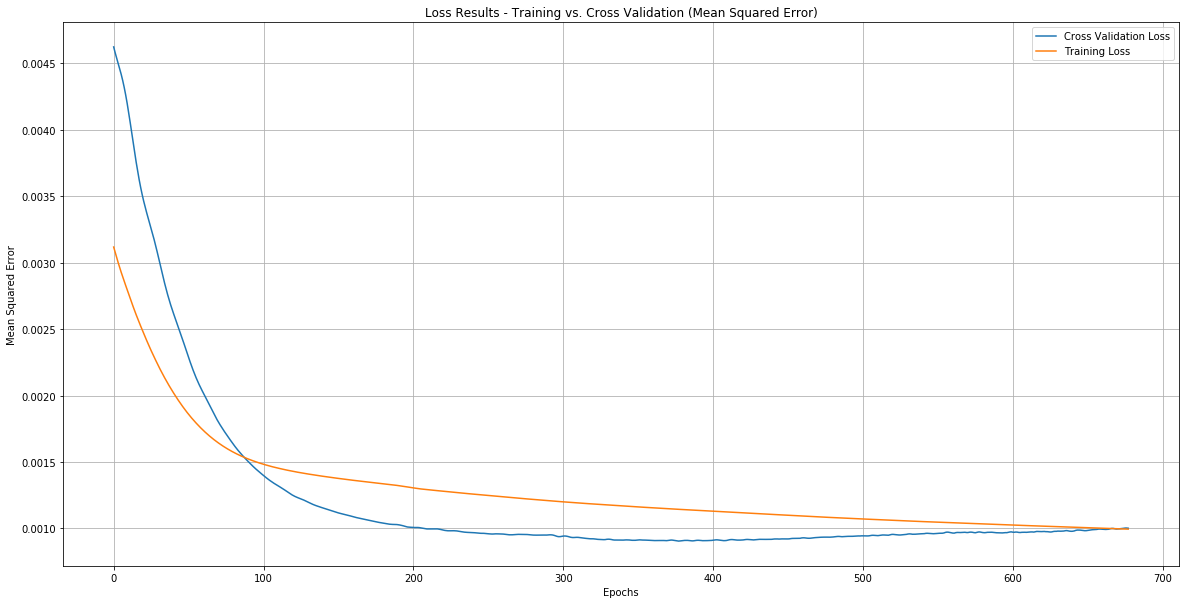

          Forecast : [393 403 417 429 461 518 587 576 517 444 418 433]
            Actual : [417 391 419 461 472 535 622 606 508 461 390 432]
Absolute Deviation : 215.45578002929688 Passengers
    Absolute Error : 3.85%


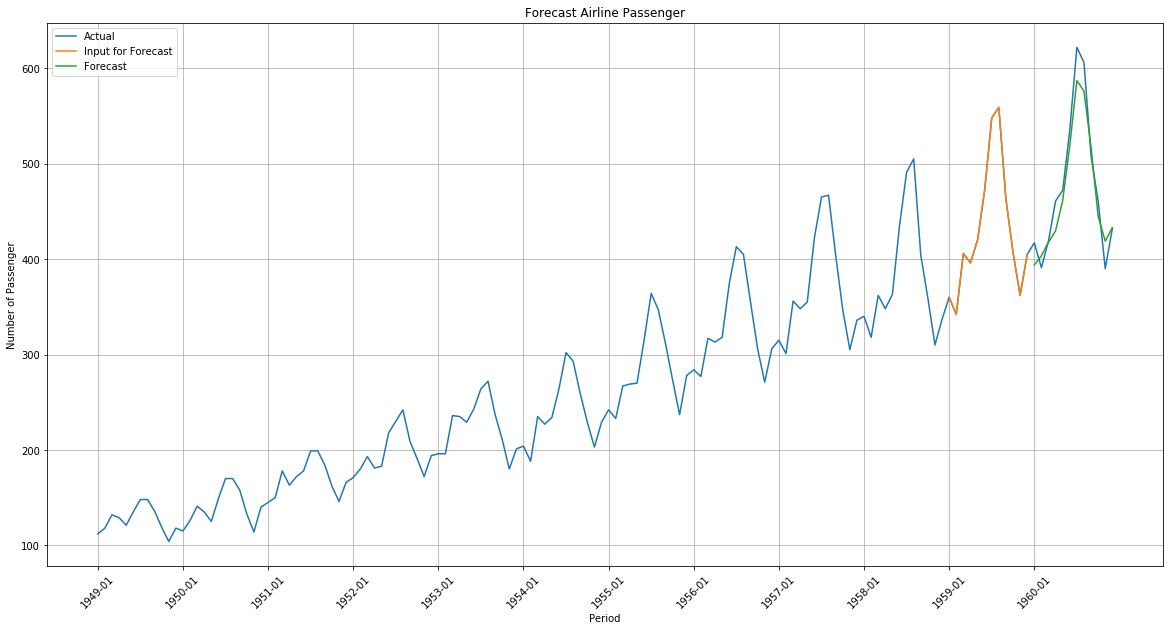

In [8]:
training_flat2=dfTraining2["PassengersScaled"].values.reshape(-1,1).astype("float32")
trainX2=[]
trainY2=[]
for i in range(len(training_flat2)-ts_target_size-ts_input_size+1):
    x=training_flat2[i:(i+ts_input_size),0]
    y=training_flat2[(i+ts_input_size):(i+ts_input_size+ts_target_size),0]
    trainX2.append(x)
    trainY2.append(y)

# Training data
trainX2=np.array(trainX2)
trainY2=np.array(trainY2)
from sklearn.model_selection import train_test_split
x_trainbatches2, x_testbatches2, y_trainbatches2, y_testbatches2 = train_test_split(
            trainX2, trainY2, test_size=0.1, random_state=42)

# Forecast input
predictX2=[training_flat2[-ts_input_size:,0]]
model2,history2=buildAndTrainModel(67,13,x_trainbatches2, x_testbatches2, y_trainbatches2, y_testbatches2,True)
show_loss(history2)
predictY2=predict(model2,predictX2,forecast_size,ts_target_size)
show_results(df,scaler.inverse_transform(predictX2),scaler.inverse_transform(predictY2))


As can be seen one missing period and the qualtity of the results are bad, but such situations are easy to find. 

### Outliners

More difficult to find are outliner. In real data they often appear if the input is human based and the figures are not as relevant as accounting figures.

In [9]:
df3=df.copy()
display(df3.loc[115])
dfTraining3=dfTraining.copy()
display(dfTraining.loc[115])
dfTraining3.at[115,'Passengers']=50
df3.at[115,'Passengers']=50
scaler3 = MinMaxScaler(feature_range = (0.1, 0.9))
series_scaled3 = scaler3.fit_transform(dfTraining3["Passengers"].values.reshape(-1,1))
dfTraining3["PassengersScaled"]=series_scaled3
display(dfTraining3.loc[115])

Period        1958-08
Passengers        505
Name: 115, dtype: object

Period               1958-08
Passengers               505
PassengersScaled    0.805055
Name: 115, dtype: object

Period              1958-08
Passengers               50
PassengersScaled        0.1
Name: 115, dtype: object

Last Results loss:0.004556805826723576, cross validation loss:0.0015439566923305392


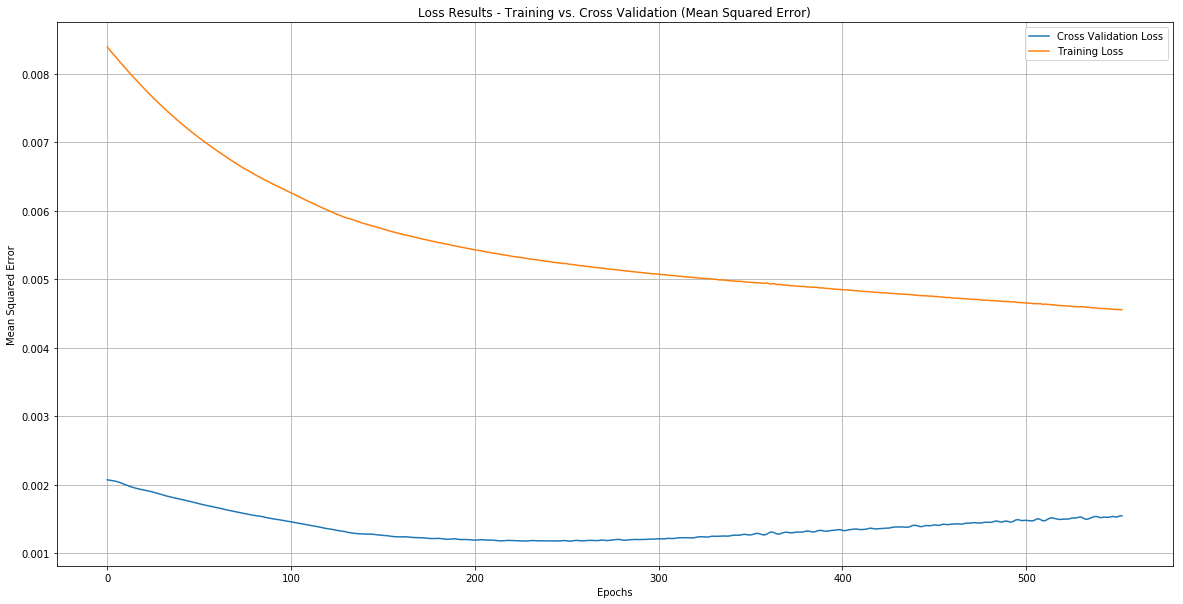

          Forecast : [403 390 407 423 443 510 517 467 449 415 400 409]
            Actual : [417 391 419 461 472 535 622 606 508 461 390 432]
Absolute Deviation : 495.7508239746094 Passengers
    Absolute Error : 9.46%


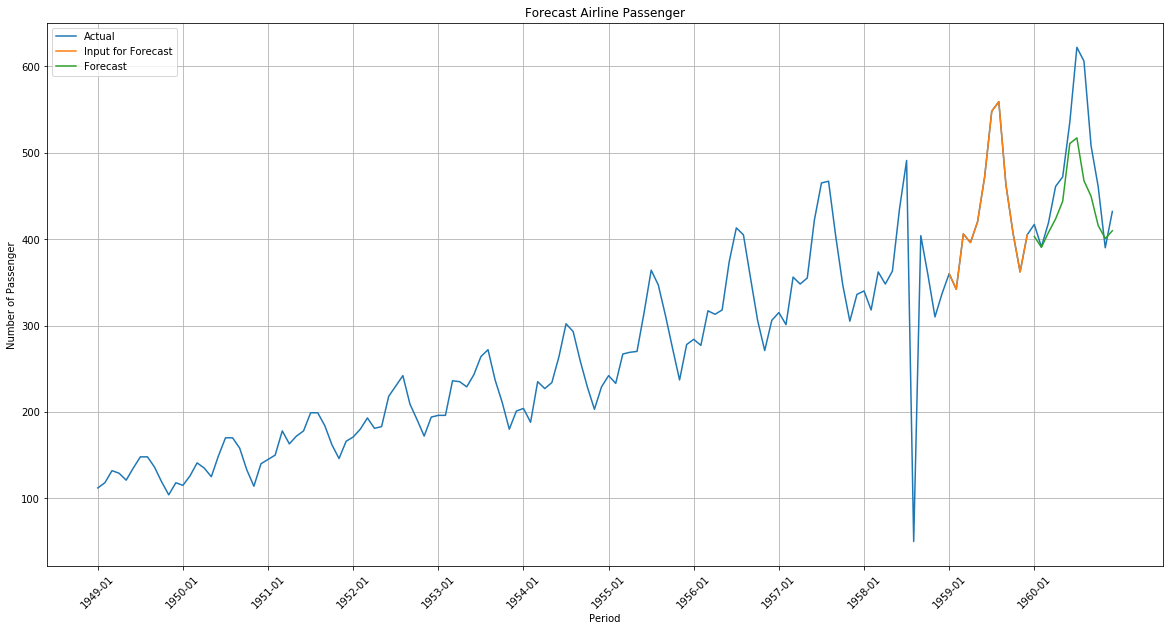

In [10]:
training_flat3=dfTraining3["PassengersScaled"].values.reshape(-1,1).astype("float32")
trainX3=[]
trainY3=[]
for i in range(len(training_flat3)-ts_target_size-ts_input_size+1):
    x=training_flat3[i:(i+ts_input_size),0]
    y=training_flat3[(i+ts_input_size):(i+ts_input_size+ts_target_size),0]
    trainX3.append(x)
    trainY3.append(y)

# Training data
trainX3=np.array(trainX3)
trainY3=np.array(trainY3)
from sklearn.model_selection import train_test_split
x_trainbatches3, x_testbatches3, y_trainbatches3, y_testbatches3 = train_test_split(
            trainX3, trainY3, test_size=0.1, random_state=42)

# Forecast input
predictX3=[training_flat3[-ts_input_size:,0]]
model3,history3=buildAndTrainModel(67,13,x_trainbatches3, x_testbatches3, y_trainbatches3, y_testbatches3,True)
show_loss(history3)
predictY3=predict(model3,predictX3,forecast_size,ts_target_size)
show_results(df3,scaler3.inverse_transform(predictX3),scaler3.inverse_transform(predictY3))
